In [1]:
from scratch.linear_algebra import Vector, dot

def predict(x: Vector, beta: Vector) -> float:
    return dot(x, beta)

In [2]:
from typing import List

def error(x: Vector, y: float, beta: Vector) -> float:
    return predict(x, beta) - y

def squared_error(x: Vector, y: float, beta: Vector) -> float:
    return error(x, y, beta) ** 2

x = [1, 2, 3]
y = 30
beta = [4, 4, 4] # so prediction = 4 + 8 + 12 = 24

assert error(x, y, beta) == -6
assert squared_error(x, y, beta) == 36

In [3]:
def sqerror_gradient(x: Vector, y: float, beta: Vector) -> Vector:
    err = error(x, y, beta)
    return [2 * err * x_i for x_i in x]

assert sqerror_gradient(x, y, beta) == [-12, -24, -36]

In [4]:
import random
import tqdm 
from scratch.linear_algebra import vector_mean
from scratch.gradient_descent import gradient_step

def least_squares_fit(xs: List[Vector], ys: List[float], learning_rate: float = 0.001, num_steps: int = 1000, batch_size: int = 1) -> Vector:
    # Start with a random guess
    guess = [random.random() for _ in xs[0]]
    for _ in tqdm.trange(num_steps, desc="least squares fit"):
        for start in range(0, len(xs), batch_size):
            batch_xs = xs[start:start+batch_size]
            batch_ys = ys[start:start+batch_size]

            gradient = vector_mean([sqerror_gradient(x, y, guess) for x, y in zip(batch_xs, batch_ys)])
            guess = gradient_step(guess, gradient, -learning_rate)
    return guess

In [5]:
from pathlib import Path

iris_dataset_file = Path() / 'datasets' / 'iris.dat'
assert iris_dataset_file.is_file(), f'{iris_dataset_file} not found'

In [6]:
import csv

y_map = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
X, y = [], []
with iris_dataset_file.open('r') as f:
    reader = csv.reader(f)
    for row in reader:
        if row:
            X.append([float(cell) for cell in row[:-1]])
            y.append(y_map[row[-1]])

In [7]:
from scratch.machine_learning import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_pct=0.25)

In [8]:
random.seed(0)
learning_rate = 0.001

beta = least_squares_fit(X_train, y_train, learning_rate, 5000, 25)
beta

least squares fit: 100%|██████████| 5000/5000 [00:00<00:00, 7992.73it/s]


[-0.10353297467815974,
 -0.003806718929497659,
 0.24867082340327806,
 0.5516033755924058]

In [9]:
from scratch.simple_linear_regression import total_sum_of_squares

def multiple_r_squared(xs: List[Vector], ys: Vector, beta: Vector) -> float:
    sum_of_squared_errors = sum(error(x, y, beta) ** 2 for x, y in zip(xs, ys))
    return 1.0 - sum_of_squared_errors / total_sum_of_squares(ys)

In [10]:
multiple_r_squared(X_train, y_train, beta)

0.923482660503906

In [11]:
from typing import TypeVar, Callable

X = TypeVar('X') # generic type for data
Stat = TypeVar('Stat') # generic type for "summary statistic"

def bootstrap_sample(data: List[X]) -> List[X]:
    """randomly samples len(data) elements with replacement"""
    return [random.choice(data) for _ in data]

def bootstrap_statistic(data: List[X], stats_fn: Callable[[List[X]], Stat], num_samples: int) -> List[Stat]:
    """evaluates stats_fn on num_samples bootstrap samples from data"""
    return [stats_fn(bootstrap_sample(data)) for _ in range(num_samples)]

In [12]:
# 101 points all very close to 100
close_to_100 = [99.5 + random.random() for _ in range(101)]

# 101 points, 50 of them near 0, 50 of them near 200
far_from_100 = (
    [99.5 + random.random()] +
    [random.random() for _ in range(50)] +
    [200 + random.random() for _ in range(50)]
)

In [13]:
from scratch.statistic import median, standard_deviation

medians_close = bootstrap_statistic(close_to_100, median, 100)
medians_far = bootstrap_statistic(far_from_100, median, 100)

sd_close = standard_deviation(medians_close)
sd_far = standard_deviation(medians_far)
sd_close, sd_far

(0.028832812995301355, 94.42142291819658)

In [14]:
assert sd_close < 1
assert sd_far > 90

In [15]:
from typing import Tuple

def estimate_sample_beta(pairs: List[Tuple[Vector, float]], learning_rate: float = 0.001, num_samples: int = 100, batch_size: int = 25) -> Vector:
    x_sample = [x for x, _ in pairs]
    y_sample = [y for _, y in pairs]
    beta = least_squares_fit(x_sample, y_sample, learning_rate, num_samples, batch_size)
    return beta

random.seed(0) # so you get the same results as me

# this will take a couple of minutes
bootstrap_betas = bootstrap_statistic(list(zip(X_train, y_train)), estimate_sample_beta, 100)

least squares fit: 100%|██████████| 100/100 [00:00<00:00, 8020.78it/s]


In [16]:
bootstrap_standard_errors = [
    standard_deviation([beta[i] for beta in bootstrap_betas]) 
    for i in range(4)
]
bootstrap_standard_errors

[0.1624158650148389,
 0.20342366422070915,
 0.13976766295331963,
 0.2545422397168833]

In [17]:
from scratch.probability import normal_cdf

def p_value(beta_hat_j: float, sigma_hat_j: float) -> float:
    if beta_hat_j > 0:
        # if the coefficient is positive, we need to compute twice the probability of seeing an even *larger* value
        return 2 * (1 - normal_cdf(beta_hat_j / sigma_hat_j))
    else:
        # otherwise twice the probability of seeing a *smaller* value
        return 2 * normal_cdf(beta_hat_j / sigma_hat_j)

assert p_value(30.58, 1.27)   < 0.001  # constant term
assert p_value(0.972, 0.103)  < 0.001  # num_friends
assert p_value(-1.865, 0.155) < 0.001  # work_hours
assert p_value(0.923, 1.249)  > 0.4    # phd

In [18]:
# alpha is a *hyperparameter* controlling how harsh the penalty is.
# Sometimes it's called "lambda" but that already means something in Python
def ridge_penalty(beta: Vector, alpha: float) -> float:
    return alpha * dot(beta[1:], beta[1:])

def squared_error_ridge(x: Vector, y: float, beta: Vector, alpha: float) -> float:
    """estimate error plus ridge penalty on beta"""
    return error(x, y, beta) ** 2 + ridge_penalty(beta, alpha)

In [19]:
from scratch.linear_algebra import add

def ridge_penalty_gradient(beta: Vector, alpha: float) -> Vector:
    """gradient of just the ridge penalty"""
    return [0.] + [2 * alpha * beta_j for beta_j in beta[1:]]

def sqerror_ridge_gradient(x: Vector, y: float, beta: Vector, alpha: float) -> Vector:
    """the gradient corresponding to the ith squared error term including the ridge penalty"""
    return add(sqerror_gradient(x, y, beta), ridge_penalty_gradient(beta, alpha))

In [20]:
def least_squares_fit_ridget(xs: List[Vector], ys: List[float], learning_rate: float = 0.001, num_steps: int = 1000, batch_size: int = 1, alpha: float = 0.0) -> Vector:
    # Start with a random guess
    guess = [random.random() for _ in xs[0]]
    for _ in tqdm.trange(num_steps, desc="least squares fit"):
        for start in range(0, len(xs), batch_size):
            batch_xs = xs[start:start+batch_size]
            batch_ys = ys[start:start+batch_size]

            gradient = vector_mean([sqerror_ridge_gradient(x, y, guess, alpha) for x, y in zip(batch_xs, batch_ys)])
            guess = gradient_step(guess, gradient, -learning_rate)
    return guess

In [27]:
random.seed(0)
beta_0 = least_squares_fit_ridget(
    X_train, y_train, alpha=0.0,
    learning_rate=learning_rate,
    num_steps=5000, batch_size=25)
beta_0

least squares fit: 100%|██████████| 5000/5000 [00:01<00:00, 4818.07it/s]


[-0.10353297467815974,
 -0.003806718929497659,
 0.24867082340327806,
 0.5516033755924058]

In [28]:
beta_0_1 = least_squares_fit_ridget(
    X_train, y_train, alpha=0.1,
    learning_rate=learning_rate,
    num_steps=5000, batch_size=25)

beta_1 = least_squares_fit_ridget(
    X_train, y_train, alpha=1,
    learning_rate=learning_rate,
    num_steps=5000, batch_size=25)

beta_10 = least_squares_fit_ridget(
    X_train, y_train, alpha=10,
    learning_rate=learning_rate,
    num_steps=5000, batch_size=25)

least squares fit: 100%|██████████| 5000/5000 [00:01<00:00, 4861.85it/s]


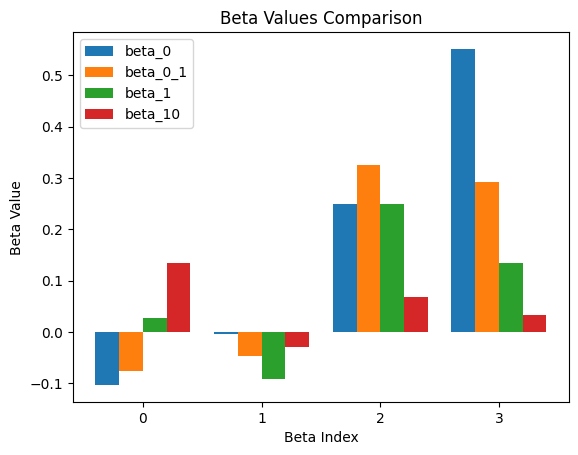

In [30]:
import matplotlib.pyplot as plt

# Define the labels and values
labels = ['beta_0', 'beta_0_1', 'beta_1', 'beta_10']
beta_values = [beta_0, beta_0_1, beta_1, beta_10]

# Create a bar chart
x = range(len(labels))
fig, ax = plt.subplots()
for i, beta in enumerate(beta_values):
    ax.bar([p + i * 0.2 for p in x], beta, width=0.2, label=labels[i])

# Add labels and title
ax.set_xlabel('Beta Index')
ax.set_ylabel('Beta Value')
ax.set_title('Beta Values Comparison')
ax.set_xticks([p + 0.3 for p in x])
ax.set_xticklabels(['0', '1', '2', '3'])
ax.legend()

# Show the plot
plt.show()

In [ ]:
def lasso_penalty(beta, alpha):
    return alpha * sum(abs(beta_i) for beta_i in beta[1:])